In [252]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression as lr
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut

In [254]:
data = pd.read_csv("../Data/10-1_dust_classes.csv")
data = data.dropna()

In [255]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,class
0,0.0,0.471296,119.958439,-0.000956,32.144038,169.758423,1053.143289,dust
1,1.0,0.085602,21.821133,0.000091,26.659139,163.944968,387.122159,dust
2,2.0,0.063896,16.289339,0.000134,27.413486,193.381032,483.033577,dust
3,3.0,0.028911,7.371473,0.000451,26.858970,146.070319,749.250395,dust
4,4.0,0.000000,0.000000,-0.002283,3.692830,196.721007,1060.959619,dust


In [256]:
data["class"].value_counts()

no_dust    1149
dust        396
Name: class, dtype: int64

In [257]:
# Show the 34% class imbalance
np.sum(data["class"] == "dust") / np.sum(data["class"] == "no_dust")

0.34464751958224543

In [258]:
lr = lr()
x = np.array(data.iloc[:,1:7])
y = np.array(data["class"])
y = [1 if name == "dust" else 0 for name in y]

In [259]:
# Use 150 folds,
# splitting the dataset into cross sections
# with roughly 10 samples.
# Get accuracy, recall, precision.

# Sometimes no positive predictions are made,
# resulting in undefined precision, recall, and auc.
loo = LeaveOneOut()
sfold = StratifiedKFold(150, shuffle=True)
lr_cv_results = cross_validate(lr, x, y, cv=sfold, scoring=["accuracy", "precision", "recall", "roc_auc"])

C:\Users\dpale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dpale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dpale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dpale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision 

In [267]:
lr_cv_acc_mean = np.mean(lr_cv_results["test_accuracy"])
lr_cv_precision_mean = np.mean(lr_cv_results["test_precision"])
lr_cv_recall_mean = np.mean(lr_cv_results["test_recall"])
lr_cv_auc_mean = np.mean(lr_cv_results["test_roc_auc"])
print("CV Scores - Averages From 150 Folds")
print("Accuracy: " + str(lr_cv_acc_mean))
print("Precision: " + str(lr_cv_precision_mean))
print("Recall: " + str(lr_cv_recall_mean))
print("AUC: " + str(lr_cv_auc_mean))

CV Scores - Averages From 150 Folds
Accuracy: 0.884909090909091
Precision: 0.8197777777777778
Recall: 0.7133333333333334
AUC: 0.935138888888889


In [261]:
def tts_predict(model, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    model.fit(x_train, y_train)
    y_prob = model.predict_proba(x_test)[:,1]
    y_predict = model.predict(x_test)
    return y_test, y_prob, y_predict

In [265]:
# Take 1000 train/test splits, 
# calculate means of precisions and accuracies
# from predictions.
precision_scores = []
recall_scores = []
auc_scores = []
acc_scores = []

for i in range(1000):
    y_test, y_prob, y_predict = tts_predict(lr, x, y)
    precision_scores.append(precision_score(y_test, y_predict))
    recall_scores.append(recall_score(y_test, y_predict))
    auc_scores.append(roc_auc_score(y_test, y_prob))
    acc_scores.append(accuracy_score(y_test, y_predict))

In [269]:
precision_mean = np.mean(precision_scores)
recall_mean = np.mean(recall_scores)
auc_mean = np.mean(auc_scores)
acc_mean = np.mean(acc_scores)

print("Linear Regression Metrics - 1000 Train/Test Splits")
print("Accuracy Mean: " + str(acc_mean))
print("Precision Mean: " + str(precision_mean))
print("Recall Mean: " + str(recall_mean))
print("AUC Mean: " + str(auc_mean))

Linear Regression Metrics - 1000 Train/Test Splits
Accuracy Mean: 0.8824470284237725
Precision Mean: 0.8115055338542311
Recall Mean: 0.7106589143499157
AUC Mean: 0.9330425369316737


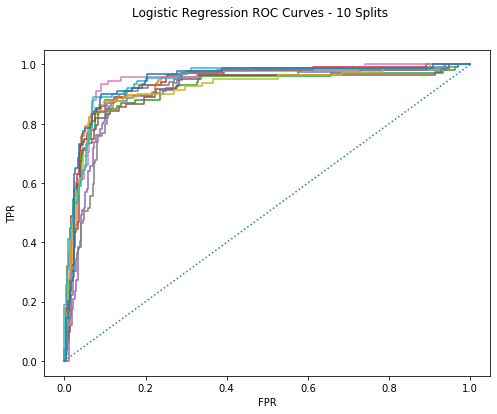

In [271]:
fig = plt.gcf()
fig.set_size_inches(8,6)
fig.suptitle("Logistic Regression ROC Curves - 10 Splits")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], linestyle="dotted")
for i in range(10):
    y_test, y_prob, y_predict = tts_predict(lr, x, y)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)